In [1]:
#process image
import keras, cv2,os
import numpy as np
from keras.utils import to_categorical
def read_image(imageName):
    img=cv2.imread(imageName,cv2.IMREAD_COLOR)
    #method1
    if img is None:
            return None;
    else:
        img = cv2.resize(img,dsize=(128,128),interpolation=cv2.INTER_LINEAR)
        img = img.astype("float32")
        img *= (1./255)
        b,g,r=cv2.split(img)
        img2=cv2.merge([r,g,b])
        return img2
        
def img_processing(path,x,y):
    directory =os.listdir(path)
    for textPath in directory:
        for fn in os.listdir(os.path.join(r"",path+ textPath)):
#             if fn.endswith('.png') or fn.endswith('.jpg'):
            fd = os.path.join(path, textPath, fn)
            img_arr=read_image(fd)
            if(img_arr is not None):
                x.append(img_arr)
                if(textPath=="ham"):
                    y.append(0)
                else:
                    y.append(1)
    return x,y  
x,y=[],[]
# get image email dataset path
path1=""

x,y=img_processing(path1,x,y)
VALIDATION_SPLIT=0.6


data = np.array(x)

labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int( VALIDATION_SPLIT* data.shape[0])
val_num=num_validation_samples+int(0.2* data.shape[0])
x_train = data[:num_validation_samples]
y_train = labels[:num_validation_samples]
x_valid = data[num_validation_samples:val_num]
y_valid = labels[num_validation_samples:val_num]
x_test = data[val_num:]
y_test = labels[val_num:]

print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)
print('x_valid.shape',x_valid.shape)
print('y_valid.shape',y_valid.shape)
print('x_test.shape',x_test.shape)
print('y_test.shape',y_test.shape)

Using TensorFlow backend.


Shape of data tensor: (2786, 128, 128, 3)
Shape of label tensor: (2786, 2)
x_train.shape (1671, 128, 128, 3)
y_train.shape (1671, 2)
x_valid.shape (557, 128, 128, 3)
y_valid.shape (557, 2)
x_test.shape (558, 128, 128, 3)
y_test.shape (558, 2)


In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,Conv2D,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization,advanced_activations,initializers
from keras import backend as K
from keras.callbacks import EarlyStopping
from PIL import Image,ImageFile
from keras import regularizers
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from sklearn import cross_validation
import os
ImageFile.LOAD_TRUNCATED_IMAGES = True
# use GPU block
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# dimensions of our images.
img_width, img_height = 128,128
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', input_shape=input_shape))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-6))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-6))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=1e-6))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

 
model.add(Flatten())
 



model.add(Dense(64))
model.add(BatchNormalization(epsilon=1e-6))
model.add(Activation("relu"))
 
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation='softmax'))
# adam = Adam(lr=0.001, beta_1=0.79, beta_2=0.999, epsilon=1e-8) 

# sgd =SGD(lr=0.01, decay=1e-6, momentum=0.89, nesterov=True)

model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=["accuracy"])
model.summary()
# ,callbacks=[early_stopping]
hist=model.fit(x=x_train, y=y_train, batch_size=32, epochs=20,validation_data=(x_valid,y_valid))
# evaluate

model.save("image_cnn_model.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
activation_9 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        51264     
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 64)        0         
__________

In [7]:
scores= model.evaluate(x_test,y_test, batch_size=32)
# scores= model.evaluate_generator(test_generator, steps=nb_train_samples // batch_size)
# print(acc)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

558/558 [==============================] - 0s 443us/step

acc: 92.29%


In [8]:
# probabilities = model.predict_generator(test_generator, steps=nb_test_samples // batch_size)
# print(probabilities)
from sklearn.metrics import classification_report
from sklearn import preprocessing   
import numpy as np
y_pred =model.predict(x_test, 32)
for i in range(len(y_pred)):
    if(y_pred[i][0]>0.5):
        y_pred[i][0]=1
    else:
        y_pred[i][0]=0
    if(y_pred[i][1]>0.5):
        y_pred[i][1]=1
    else:
        y_pred[i][1]=0

print(classification_report(y_test,y_pred))
# print(y_pred)

             precision    recall  f1-score   support

          0       0.88      0.97      0.93       279
          1       0.97      0.87      0.92       279

avg / total       0.93      0.92      0.92       558



In [9]:
# get f1-score and recall
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,recall_score
print("f1_score：",f1_score(y_test,y_pred,average = 'macro'))
print("recall_score：",recall_score(y_test,y_pred,average = 'macro'))

f1_score： 0.9227303613580957
recall_score： 0.9229390681003584


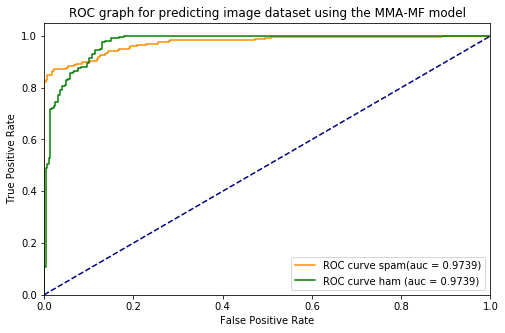

In [10]:
from sklearn.metrics import roc_curve,auc
y_score=model.predict(x_test, 32)
n_classes=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])    
    roc_auc[i] = auc(fpr[i], tpr[i])   

# #Plot of a ROC curve for a specific class
plt.rcParams['figure.figsize']=(8,5)
plt.figure()
plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve spam(auc = %0.4f)' % roc_auc[1])
plt.plot(fpr[0], tpr[0], color='green', label='ROC curve ham (auc = %0.4f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC graph for predicting image dataset using the MMA-MF model')
plt.legend(loc="lower right")
plt.savefig('/home/zsj/luoyang/spam_final/spam-experiment-paper/ROC_graph_for_Image.png')
plt.show()


# plt.figure()
# lw = 2
# # plt.figure(figsize=(10,10))
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()
